# Preprocessing

This jupyter notebook is to preprocess the data from MIMIC and REFLACX to form a dataframe `reflacx_with_clinical.csv` in this repository for training purpose. In the preprocessing phase, we use the metadata table from *REFLACX* dataset as the main table to *left join* three other tables that contian the image and clinical data we want:

- Metadata table from CXR, this data table contain the information about the CXR images, such as height, width and `subject_id`.
- Patient table from MIMIC-IV - CORE, this table contain the information we want, inlcluding gender and age.
- Triage table from MIMIC-IV ED, this table contain the patients' health condition while in emergency department.

Moreover, this notebook also perform data cleaning and filling missing value.

At the end of the notebook, a `reflacx_with_clinical.csv` will be exported to the root of the working directory, so the dataloader can load this file to get training data.

In [1]:
import os, json
import pandas as pd

from data.paths import TabularDataPaths
from utils import print as print_f
from utils.preprocessing import get_split_list
from data.constants import XAMI_MIMIC_PATH, SPREADSHEET_FOLDER
from utils.init import reproducibility

In [2]:
seed = 0
reproducibility(0)

XAMI_MIMIC_PATH_str = "{XAMI_MIMIC_PATH}"

In [3]:
reflacx_meta_df = pd.read_csv(
    TabularDataPaths.SpreadSheet.get_sreadsheet(
        XAMI_MIMIC_PATH, TabularDataPaths.SpreadSheet.REFLACX.metadata,
    )
)
reflacx_meta_df.head(5)


,Unnamed: 0,id,split,eye_tracking_data_discarded,image,dicom_id,subject_id,image_size_x,image_size_y,Airway wall thickening,...,Support devices,Wide mediastinum,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality
0,0,P102R108387,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,P102R379837,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,P102R558314,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,4.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,P102R765317,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,P102R915878,train,False,physionet.org/files/mimic-cxr/2.0.0/files/p18/...,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,2544,3056,0.0,...,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
reflacx_meta_df.columns

Index(['Unnamed: 0', 'id', 'split', 'eye_tracking_data_discarded', 'image',
       'dicom_id', 'subject_id', 'image_size_x', 'image_size_y',
       'Airway wall thickening', 'Atelectasis', 'Consolidation', 'Emphysema',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Mass', 'Nodule', 'Other', 'Pleural effusion',
       'Pleural thickening', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality'],
      dtype='object')

## Define columns in their own categories

In [7]:
labels_cols = [
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Fracture",
    "Groundglass opacity",
    "Pneumothorax",
    "Pulmonary edema",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Quality issue",
    "Support devices",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
]


## inlcude the repetitive columns.
all_disease_cols = [
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Emphysema",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Fracture",
    "Groundglass opacity",
    "Mass",
    "Nodule",
    "Other",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary edema",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
]


## Filling NAN value.

In [8]:
def checkMissingValue(df):
    print(
        [
            (col, sum(df[col].isna()))
            for col in df.columns
            if df[col].isna().any()
        ]
    )

In [9]:
len(reflacx_meta_df)

3052

In [10]:
# Checking the columns that contian nan values.
print_f.print_title("Columns have NaN value in REFLACX metadata")
checkMissingValue(reflacx_meta_df)

====================Columns have NaN value in REFLACX metadata====================
[('Airway wall thickening', 2757), ('Emphysema', 2757), ('Fibrosis', 2757), ('Fracture', 2757), ('Mass', 2757), ('Nodule', 2757), ('Other', 2839), ('Pleural effusion', 2757), ('Pleural thickening', 2757), ('Quality issue', 2757), ('Wide mediastinum', 2757), ('Abnormal mediastinal contour', 295), ('Acute fracture', 295), ('Enlarged hilum', 295), ('Hiatal hernia', 295), ('High lung volume / emphysema', 295), ('Interstitial lung disease', 295), ('Lung nodule or mass', 295), ('Pleural abnormality', 295)]


In [11]:
# Filling nan for numerical cols.
reflacx_meta_df[all_disease_cols] = reflacx_meta_df[all_disease_cols].fillna(0)

# Folling nan for boolean cols.
reflacx_meta_df[["Quality issue", "Support devices"]] = reflacx_meta_df[
    ["Quality issue", "Support devices"]
].fillna(False)



## Checking again that all columns don't contain nan value.

In [12]:
print_f.print_title("Columns have missing value in REFLACX metadata.")

checkMissingValue(reflacx_meta_df)


====================Columns have missing value in REFLACX metadata.====================
[]


## Relabel repetitive columns

In [13]:
reflacx_meta_df["Lung nodule or mass"] = reflacx_meta_df[
    ["Lung nodule or mass", "Mass", "Nodule"]
].max(axis=1)
del reflacx_meta_df["Mass"]
del reflacx_meta_df["Nodule"]

reflacx_meta_df["High lung volume / emphysema"] = reflacx_meta_df[
    ["High lung volume / emphysema", "Emphysema"]
].max(axis=1)
del reflacx_meta_df["Emphysema"]


reflacx_meta_df["Pleural abnormality"] = reflacx_meta_df[
    ["Pleural abnormality", "Pleural thickening", "Pleural effusion"]
].max(axis=1)
del reflacx_meta_df["Pleural thickening"]
del reflacx_meta_df["Pleural effusion"]



## Load the dataframe that we wanna join with relfacx metaadta

In [28]:
cxr_meta_df = pd.read_csv(
    'E:\\XAMI-MIMIC 2.0\\spreadsheets\\cxr_meta.csv'
)
core_patients_df = pd.read_csv("E:\\physionet.org\\files\\mimiciv\\2.0\\hosp\\patients.csv.gz")
ed_triage_df =  pd.read_csv("E:\\physionet.org\\files\\mimic-iv-ed\\2.0\\ed\\triage.csv.gz")



## Join dataframes

In [25]:
cxr_meta_df = pd.read_csv("E:\\physionet.org\\files\\mimic-cxr-jpg\\2.0.0\\mimic-cxr-2.0.0-metadata.csv.gz")

In [27]:
TabularDataPaths.SpreadSheet.get_sreadsheet(
        XAMI_MIMIC_PATH, TabularDataPaths.SpreadSheet.cxr_meta
    )

'D:\\XAMI-MIMIC\\spreadsheets\\cxr_meta.csv'

In [17]:
merged_df = (
    reflacx_meta_df.merge(
        cxr_meta_df,
        "left",
        left_on="dicom_id",
        right_on="dicom_id",
        suffixes=("", "cxr"),
    )
    .merge(core_patients_df, "left", on="subject_id", suffixes=("", "_patient"))
    .merge(ed_triage_df, "left", on="stay_id", suffixes=("", "_triage"))
)



In [20]:
reflacx_meta_df['stay_id']

KeyError: 'stay_id'

In [19]:
merged_df['stay_id']

0       32067002.0
1       32067002.0
2       32067002.0
3       32067002.0
4       32067002.0
           ...    
3047           NaN
3048           NaN
3049           NaN
3050           NaN
3051           NaN
Name: stay_id, Length: 3052, dtype: float64

In [14]:
cxr_meta_df.columns

Index(['Unnamed: 0', 'dicom_id', 'subject_id', 'study_id',
       'PerformedProcedureStepDescription', 'ViewPosition', 'Rows', 'Columns',
       'StudyDate', 'StudyTime', 'ProcedureCodeSequence_CodeMeaning',
       'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'in_eye_gaze',
       'in_reflacx', 'StudyDateTime', 'stay_id'],
      dtype='object')

In [15]:
reflacx_meta_df.columns

Index(['Unnamed: 0', 'id', 'split', 'eye_tracking_data_discarded', 'image',
       'dicom_id', 'subject_id', 'image_size_x', 'image_size_y',
       'Airway wall thickening', 'Atelectasis', 'Consolidation',
       'Enlarged cardiac silhouette', 'Fibrosis', 'Fracture',
       'Groundglass opacity', 'Other', 'Pneumothorax', 'Pulmonary edema',
       'Quality issue', 'Support devices', 'Wide mediastinum',
       'Abnormal mediastinal contour', 'Acute fracture', 'Enlarged hilum',
       'Hiatal hernia', 'High lung volume / emphysema',
       'Interstitial lung disease', 'Lung nodule or mass',
       'Pleural abnormality'],
      dtype='object')

## Only keep the cases with identified `stay_id`

In [16]:
# ! If I tracking data is needed, we need to uncomment this one.
merged_df = merged_df[~merged_df["eye_tracking_data_discarded"]]

## only get the one with `stay_id`, so we can link to triage.csv
merged_df = merged_df[~merged_df["stay_id"].isna()]
merged_df["stay_id"] = merged_df["stay_id"].astype(int)



##  Calculate the age according to the time when the CXR taken.

In [17]:
merged_df["age"] = merged_df["anchor_age"] + (
    merged_df["StudyDate"].apply(lambda x: int(str(x)[:4])) - merged_df["anchor_year"]
)

## Generating path for *CXR image* and *bounding ellipses*.
We do this so we can locat them easily during training. When we load the data, we need to replace the `XAMI_MIMIC_PATH` in the path string to get the correct path to desired files.

In [18]:
## Calculate the age according to the time when the CXR taken.
merged_df["image_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + merged_df["subject_id"].astype(str)
    + "\CXR-JPG\s"
    + merged_df["study_id"].astype(str)
    + "\\"
    + merged_df["dicom_id"].astype(str)
    + ".jpg"
)
merged_df["anomaly_location_ellipses_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + merged_df["subject_id"].astype(str)
    + "\REFLACX\\"
    + merged_df["id"].astype(str)
    + "\\anomaly_location_ellipses.csv"
)

merged_df["fixations_path"] = (
    f"{XAMI_MIMIC_PATH_str}\patient_"
    + merged_df["subject_id"].astype(str)
    + "\REFLACX\\"
    + merged_df["id"].astype(str)
    + "\\fixations.csv"
)





# features filtering
By indentified our needed columns, we can filter out the features we don't need.

In [19]:
needed_columns = [
    # ids
    "id",
    "dicom_id",
    "subject_id",
    "stay_id",
    "study_id",
    # image meta
    "image_path",
    "ViewPosition",
    "image_size_x",
    "image_size_y",
    "anomaly_location_ellipses_path",
    "fixations_path",
    # patients
    "age",
    "gender",
    # triage
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    "pain",
    "acuity",
    # labels
    "Airway wall thickening",
    "Atelectasis",
    "Consolidation",
    "Enlarged cardiac silhouette",
    "Fibrosis",
    "Groundglass opacity",
    "Other",
    "Pneumothorax",
    "Pulmonary edema",
    "Quality issue",
    "Support devices",
    "Wide mediastinum",
    "Abnormal mediastinal contour",
    "Acute fracture",
    "Enlarged hilum",
    "Hiatal hernia",
    "High lung volume / emphysema",
    "Interstitial lung disease",
    "Lung nodule or mass",
    "Pleural abnormality",
    'Fracture' # don't have any positive case
]

merged_df = merged_df[needed_columns]


# Filling NaN value in the merged table.
Previously, we have filled the missing value for `reflacx_meta_df`. However, more features are introduced while we added more columns thorugh left-joining other tables. Therefore, we need to replace the missing value that come from other table.

In [20]:
# Checking the columns that contian nan values (from other joined table).
print_f.print_title("Columns have missing value in merged_df")
checkMissingValue(merged_df)


====================Columns have missing value in merged_df====================
[('temperature', 75), ('heartrate', 61), ('resprate', 69), ('o2sat', 65), ('sbp', 62), ('dbp', 64), ('pain', 83), ('acuity', 24)]


### Filling NaN value by mean

In [22]:
# filling the nan value by mean

for col in merged_df.columns:
    if merged_df[col].isna().any():
        filling_value = round(merged_df[~merged_df[col].isna()][col].mean(), 1)
        print(f"filling missing value for {col} by value {filling_value:.2f}")
        merged_df[col] = merged_df[col].fillna(filling_value)


filling missing value for temperature by value 98.10
filling missing value for heartrate by value 85.70
filling missing value for resprate by value 18.50
filling missing value for o2sat by value 97.60
filling missing value for sbp by value 132.30
filling missing value for dbp by value 72.40
filling missing value for pain by value 4.10
filling missing value for acuity by value 2.20


## Split them into train, val and test set.

In [22]:
merged_df['split'] = get_split_list(len(merged_df), train_portion=0.7)

## The end of the dataframe looks like this: 

In [28]:
merged_df.age.mean()

66.30746268656716

In [23]:
len(merged_df)

670

In [24]:
merged_df.head(5)

,id,dicom_id,subject_id,stay_id,study_id,image_path,ViewPosition,image_size_x,image_size_y,anomaly_location_ellipses_path,...,Abnormal mediastinal contour,Acute fracture,Enlarged hilum,Hiatal hernia,High lung volume / emphysema,Interstitial lung disease,Lung nodule or mass,Pleural abnormality,Fracture,split
0,P102R108387,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,3056,{XAMI_MIMIC_PATH}\patient_18111516\REFLACX\P10...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
1,P102R379837,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,3056,{XAMI_MIMIC_PATH}\patient_18111516\REFLACX\P10...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,val
2,P102R558314,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,3056,{XAMI_MIMIC_PATH}\patient_18111516\REFLACX\P10...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,P102R765317,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,3056,{XAMI_MIMIC_PATH}\patient_18111516\REFLACX\P10...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train
4,P102R915878,34cedb74-d0996b40-6d218312-a9174bea-d48dc033,18111516,32067002,55032240,{XAMI_MIMIC_PATH}\patient_18111516\CXR-JPG\s55...,AP,2544,3056,{XAMI_MIMIC_PATH}\patient_18111516\REFLACX\P10...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [25]:
from collections import OrderedDict

count_map = dict((merged_df[labels_cols]>0).sum(axis=0))
OrderedDict({k: v for k, v in sorted(count_map.items(), key=lambda item: item[1])})

OrderedDict([('Fracture', 0),
             ('Fibrosis', 1),
             ('Pneumothorax', 2),
             ('Wide mediastinum', 3),
             ('Quality issue', 3),
             ('Airway wall thickening', 4),
             ('Acute fracture', 4),
             ('Hiatal hernia', 7),
             ('Interstitial lung disease', 11),
             ('Enlarged hilum', 12),
             ('High lung volume / emphysema', 19),
             ('Abnormal mediastinal contour', 20),
             ('Lung nodule or mass', 42),
             ('Groundglass opacity', 61),
             ('Pulmonary edema', 85),
             ('Consolidation', 112),
             ('Pleural abnormality', 138),
             ('Atelectasis', 143),
             ('Enlarged cardiac silhouette', 154),
             ('Support devices', 189)])

## Output the preprocessed data to `reflacx_with_clinical.csv`.
We can export the preprocessed data to the root of local working, so other dataloaders can load them while training. 

In [26]:
merged_df = merged_df.reset_index()
merged_df.to_csv(os.path.join(SPREADSHEET_FOLDER, "reflacx_with_clinical.csv"))

# Create another Dataframe for unique `dicom_id`

In [27]:
u_idxs = [merged_df.dicom_id.eq(u_id).idxmax() for u_id in merged_df.dicom_id.unique()]

In [28]:
u_df = merged_df.loc[u_idxs]
u_df['split'] = get_split_list(len(u_df), train_portion=0.7)

## Remap the bounding bxoes and fixations to a single CXR image

In [29]:
all_bbox_paths = []
all_fixations_paths = []

for idx, row in u_df.iterrows():
    bbox_paths = list(merged_df[merged_df.dicom_id.eq(row['dicom_id'])]['anomaly_location_ellipses_path'])
    fixatinos_paths = list(merged_df[merged_df.dicom_id.eq(row['dicom_id'])]['fixations_path'])
    all_bbox_paths.append(json.dumps(bbox_paths))
    all_fixations_paths.append(json.dumps(fixatinos_paths))

u_df['bbox_paths'] = all_bbox_paths
u_df['fixations_path'] = all_fixations_paths


In [30]:
from collections import OrderedDict

count_map = dict((u_df[labels_cols] >0 ).sum(axis=0))
OrderedDict({k: v for k, v in sorted(count_map.items(), key=lambda item: item[1])})

OrderedDict([('Fibrosis', 0),
             ('Fracture', 0),
             ('Wide mediastinum', 0),
             ('Airway wall thickening', 1),
             ('Quality issue', 1),
             ('Pneumothorax', 2),
             ('Acute fracture', 4),
             ('Hiatal hernia', 6),
             ('Interstitial lung disease', 9),
             ('Enlarged hilum', 12),
             ('High lung volume / emphysema', 15),
             ('Abnormal mediastinal contour', 17),
             ('Lung nodule or mass', 35),
             ('Groundglass opacity', 53),
             ('Pulmonary edema', 71),
             ('Consolidation', 101),
             ('Atelectasis', 117),
             ('Pleural abnormality', 117),
             ('Enlarged cardiac silhouette', 127),
             ('Support devices', 169)])

In [31]:
import matplotlib.pyplot as plt

def sort_dict(d, desc=True):
    return dict(sorted(d.items(), key=lambda item: item[1] * (1 if desc else -1) ))
    
def plot_dist(count_dict, fig_size =(20,10)):
    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=fig_size)
    keys_list = list(count_dict.keys())
    plt.barh(keys_list, [ count_dict[k] for k in keys_list])

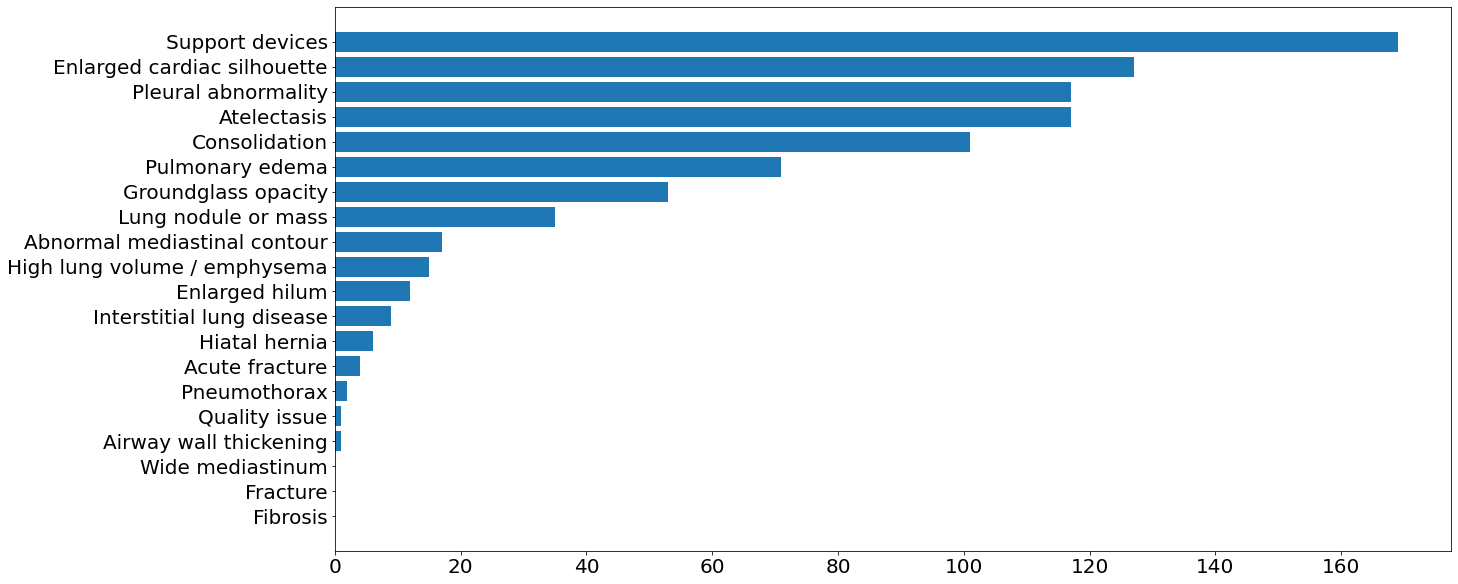

In [32]:
plot_dist(sort_dict(count_map))

In [33]:
u_df = u_df.reset_index()
u_df.to_csv(os.path.join(SPREADSHEET_FOLDER, 'reflacx_u_df.csv'))